# To-Do List (Revised)

***Feature Engineering***
- Class weighting (Done)
- Data normalization / standardization
- Augmentation
- Feature extraction
    - HOG (Done)
    - Landmarks
    - Gradients
- Dimensionality reduction (PCA or selection for Fuzzy system)

***Models***
- SVM (Done)
- Random Forest
- MLP
- Fuzzy System (needs reduced feature set)

***Hyperparameter Tuning***

***Evaluation***
- Compute Accuracy + Balanced Accuracy
- Confusion Matrix (Validation + Test) for each model

***Comparison***
- Table comparing all models
- Discuss strengths / weaknesses / overfitting

***Real-Time Demo***
- Use only the best model
- Confirm correct model loading (joblib.load)
- Display predicted emotion labels

# Emotion Recognition Using HOG Features and SVM Classifier

This notebook implements facial emotion recognition using the FER2013 dataset.  
The process includes:
1. Data loading and preprocessing  
2. Handling class imbalance  
3. Extracting Histogram of Oriented Gradients (HOG) features  
4. Training a Support Vector Machine (SVM) classifier  
5. Evaluating the model on validation (PublicTest) and test (PrivateTest) sets  
6. Visualizing results (class imbalance, HOG features, confusion matrices)  
7. Running a real-time emotion detection demo using OpenCV

In [ ]:
import graphviz

dot = graphviz.Digraph('ERD', format='png')

dot.attr(rankdir='LR', fontsize='12')

# Entities
dot.node('Student', 'Student\n(StudentID, FirstName, LastName, Email, BirthDate, EnrollmentYear)', shape='box')
dot.node('DegreeProgram', 'DegreeProgram\n(ProgramID, ProgramName, DegreeType, Duration)', shape='box')
dot.node('Department', 'Department\n(DeptID, DeptName, Building)', shape='box')
dot.node('Instructor', 'Instructor\n(InstructorID, FirstName, LastName, Email, Rank)', shape='box')
dot.node('Course', 'Course\n(CourseID, Title, Description, Credits, Semester)', shape='box')
dot.node('CourseOffering', 'CourseOffering\n(OfferingID, Semester, Year, Schedule)', shape='box')

# Relationships
dot.edge('Student', 'DegreeProgram', label='enrolledIn (n,1)')
dot.edge('Department', 'DegreeProgram', label='offersProgram (1,n)')
dot.edge('Department', 'Course', label='offersCourse (1,n)')
dot.edge('Instructor', 'Department', label='worksIn (n,1)')
dot.edge('Instructor', 'Instructor', label='mentors (1,n)')
dot.edge('Course', 'CourseOffering', label='hasOffering (1,n)')
dot.edge('CourseOffering', 'Instructor', label='taughtBy (n,m)')
dot.edge('Student', 'CourseOffering', label='enrollsIn (n,m)')
dot.edge('Course', 'Course', label='hasPrerequisite (n,m)')

# Output file
dot.render('university_ERD', view=False)
print('ER Diagram generated: university_ERD.png')

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from skimage import exposure
from skimage.feature import hog
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

## 1. Data Loading and Splitting
The FER2013 dataset includes three partitions under the column `Usage`:
- **Training**: used to fit the model  
- **PublicTest**: used for validation (hyperparameter tuning)  
- **PrivateTest**: used for final testing (reporting generalization performance)

In [4]:
# Read FER2013 dataset
df = pd.read_csv("fer2013.csv")

# Split data by Usage column
train_df = df[df["Usage"] == "Training"].copy()
val_df   = df[df["Usage"] == "PublicTest"].copy()
test_df  = df[df["Usage"] == "PrivateTest"].copy()

# Emotion label mapping
emotion_labels = {
    0: "angry", 1: "disgust", 2: "fear",
    3: "happy", 4: "sad", 5: "surprise", 6: "neutral"
}

# Display dataset sizes
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 28709
Validation size: 3589
Test size: 3589


## 2. Preprocessing
Each sample in the dataset is stored as a string of pixel values.  
These steps convert the strings to 48×48 grayscale arrays and normalize them to the range [0, 1].

In [3]:
# Convert pixel strings to 48×48 arrays and normalize
X_train = np.vstack([np.fromstring(x, sep=' ') for x in train_df['pixels']]).reshape(-1, 48, 48) / 255.0
y_train = train_df['emotion'].values

X_val   = np.vstack([np.fromstring(x, sep=' ') for x in val_df['pixels']]).reshape(-1, 48, 48) / 255.0
y_val   = val_df['emotion'].values

X_test  = np.vstack([np.fromstring(x, sep=' ') for x in test_df['pixels']]).reshape(-1, 48, 48) / 255.0
y_test  = test_df['emotion'].values

## 3. Handling Class Imbalance
The FER2013 dataset is not evenly distributed among emotions.  
To avoid bias toward majority classes, class weights are computed and visualized.
## why class weight

# Class Weight

Class weights: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8491274770777877, 5: 1.293372978330405, 6: 0.8260394187886635}


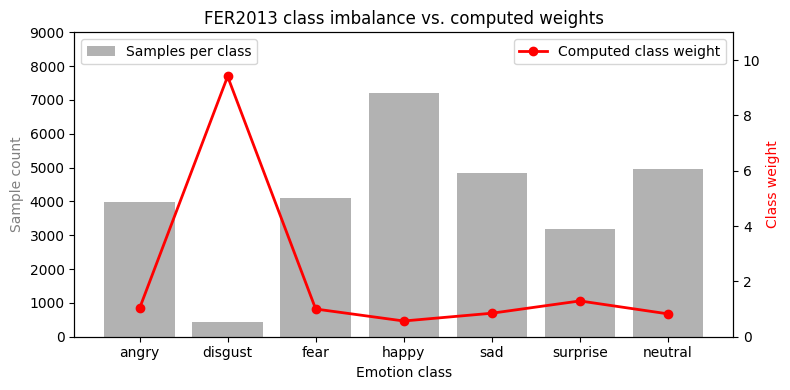

In [4]:
# Compute class weights for imbalanced data
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

# Visualize sample counts and class weights
counts = pd.Series(y_train).value_counts().sort_index()
emotion_names = [emotion_labels[i] for i in sorted(emotion_labels.keys())]

fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()
ax1.bar(emotion_names, counts, color="gray", alpha=0.6, label="Samples per class")
ax2.plot(emotion_names, weights, color="red", marker="o", linewidth=2, label="Computed class weight")

ax1.set_xlabel("Emotion class")
ax1.set_ylabel("Sample count", color="gray")
ax2.set_ylabel("Class weight", color="red")
ax1.set_ylim(0, 9000)
ax2.set_ylim(0, 11)
ax1.set_title("FER2013 class imbalance vs. computed weights")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

## 4. HOG Feature Extraction Overview
HOG (Histogram of Oriented Gradients) captures edge and texture information instead of raw pixel intensity.  
Each 48×48 image is divided into 8×8 cells. Gradients are computed per cell and normalized over 2×2 cell blocks (16×16 pixel area).  
The concatenated histograms form a 1D feature vector that represents the image structure.

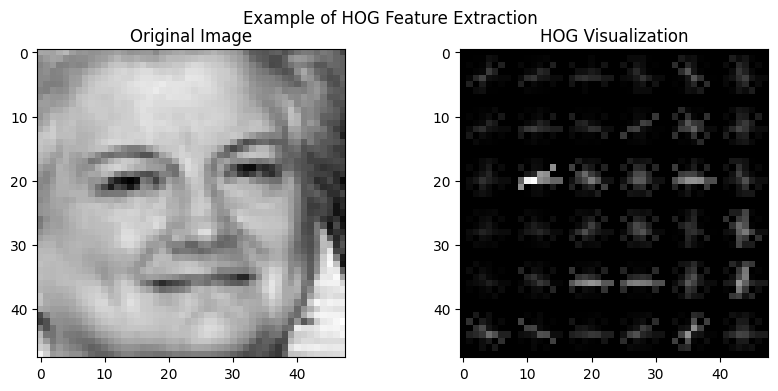

Feature shapes:
Train: (28709, 900) Val: (3589, 900) Test: (3589, 900)


In [5]:
# Example: visualize HOG feature extraction on one image
sample_img = X_train[100]
fd, hog_image = hog(sample_img, pixels_per_cell=(8,8), cells_per_block=(2,2),
                    visualize=True, feature_vector=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.imshow(sample_img, cmap='gray')
ax1.set_title("Original Image")
ax2.imshow(exposure.rescale_intensity(hog_image, in_range=(0,10)), cmap='gray')
ax2.set_title("HOG Visualization")
plt.suptitle("Example of HOG Feature Extraction")
plt.show()
# Function to extract HOG features for all images
def extract_hog_features(images):
    """Extract Histogram of Oriented Gradients (HOG) features for each image."""
    feats = []
    for img in images:
        # Compute HOG features for one image
        # pixels_per_cell=(8,8): divides the image into 8×8 cells
        # cells_per_block=(2,2): performs normalization over a 16×16 area (2×2 cells)
        # feature_vector=True: flattens the result into a 1D vector
        feat = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        feats.append(feat)
    # Convert list of vectors into a 2D NumPy array: (num_images, num_features)
    return np.array(feats)

# Extract features for train, validation, and test sets
X_train_hog = extract_hog_features(X_train)
X_val_hog   = extract_hog_features(X_val)
X_test_hog  = extract_hog_features(X_test)

print("Feature shapes:")
print("Train:", X_train_hog.shape, "Val:", X_val_hog.shape, "Test:", X_test_hog.shape)

## 5. Training Model

5.1 SVM model
A Support Vector Machine with an RBF kernel is used.  
It learns non-linear decision boundaries in the HOG feature space.  
The class weights are passed to handle imbalanced classes.

In [ ]:
############### 
##  15 min   ## 
############### 
svm = SVC(
    kernel='rbf',
    C=2.0,
    gamma='scale',
    class_weight=class_weights,
    probability=False,
    random_state=42
)
svm.fit(X_train_hog, y_train)
Path("models").mkdir(exist_ok=True)
joblib.dump(svm, "models/svm_model.pkl")
print("SVM model trained and saved to models/svm_model.pkl")

SVM model trained and saved to models/svm_model.pkl


5.2 Hyperparameter Tuning

In [1]:
pass

## 6. Evaluation on Validation (PublicTest)
The validation set is used to assess model tuning and generalization before final testing.

Validation Accuracy (PublicTest): 0.5626


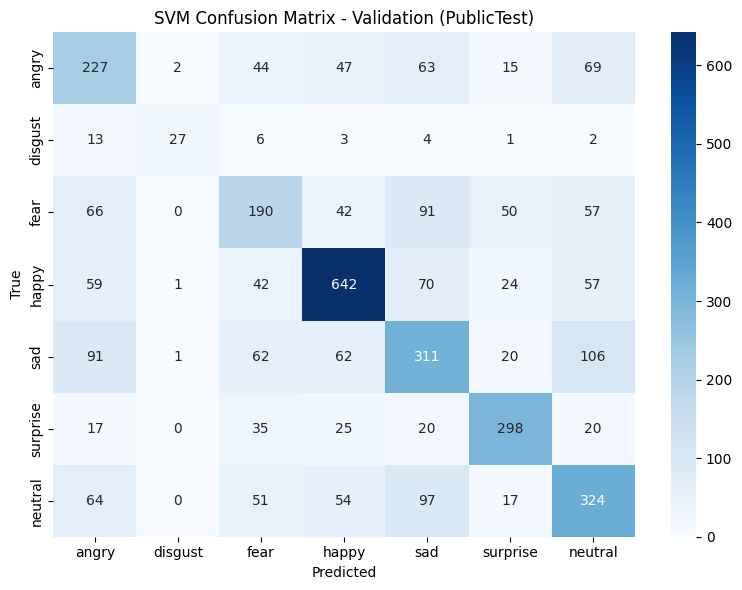

In [7]:
# Predict on validation data
y_pred_val = svm.predict(X_val_hog)
val_acc = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy (PublicTest): {val_acc:.4f}")

# Plot confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8,6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues",
            xticklabels=[emotion_labels[i] for i in range(7)],
            yticklabels=[emotion_labels[i] for i in range(7)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM Confusion Matrix - Validation (PublicTest)")
plt.tight_layout()
plt.show()

## 7. Evaluation on Test (PrivateTest)
This step measures final model performance on unseen data.

Test Accuracy (PrivateTest): 0.5550


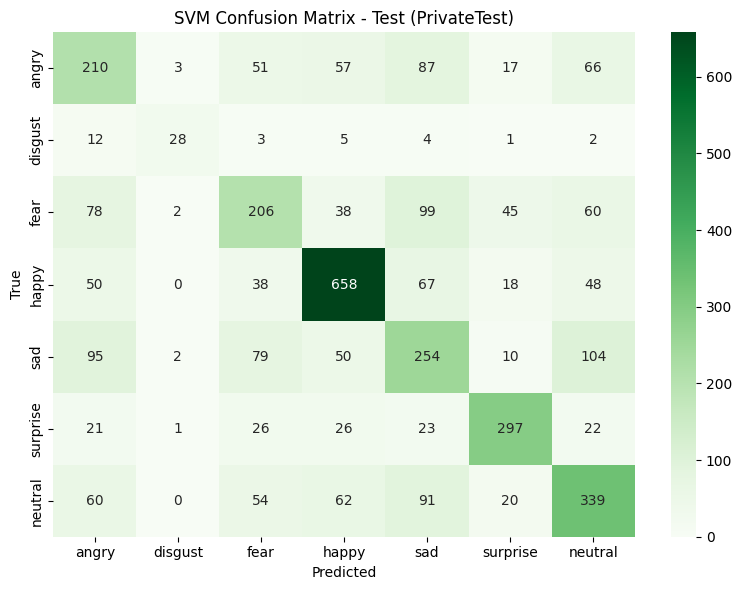

In [8]:
# Predict on private test data
y_pred_test = svm.predict(X_test_hog)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy (PrivateTest): {test_acc:.4f}")

# Plot confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens",
            xticklabels=[emotion_labels[i] for i in range(7)],
            yticklabels=[emotion_labels[i] for i in range(7)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM Confusion Matrix - Test (PrivateTest)")
plt.tight_layout()
plt.show()

## 8. Real-Time Emotion Recognition Demo
A real-time demo is created using OpenCV to:
1. Capture video frames from the webcam  
2. Detect faces using a Haar cascade  
3. Apply HOG feature extraction  
4. Predict emotion using the trained SVM model

In [5]:
# Load trained model
svm = joblib.load("models/svm_model.pkl")

# Load face detection cascade
face_cascade = cv2.CascadeClassifier("models/haarcascade_frontalface_default.xml")

# Start webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        # Crop detected face region
        roi = cv2.resize(gray[y:y+h, x:x+w], (48,48)) / 255.0

        # Extract HOG features and predict emotion
        feat = hog(roi, pixels_per_cell=(8,8), cells_per_block=(2,2), feature_vector=True).reshape(1, -1)
        pred = svm.predict(feat)[0]
        label = emotion_labels.get(pred, "unknown")

        # Draw bounding box and label on frame
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

    # Display the video stream
    cv2.imshow("Emotion Recognition", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1